**Student Name - Aditya Bhavsar**

## Define Model

$$
\begin{matrix}
\text{Input 1: text}, X_1 & \rightarrow & \text{embed}: E(X_1) & \rightarrow & N_1(E(X_1)) \\
  & & & & \searrow \\
  & & & &          & \oplus \rightarrow N_3 \bigg( \underbrace{N_1(E(X_1))}_\text{text}, \underbrace{N_2(X_2)}_\text{func rating} \bigg) \\
  & & & & \nearrow \\
& & \text{Input 2: function rating}, X_2 & \rightarrow & N_2(X_2) \\
\end{matrix}
$$

#Import required libraries

In [ ]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, Lambda
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from huggingface_hub import HfApi

# Load tokenizer and model

In [ ]:
# Setting Hugging face token
import os
os.environ["HF_TOKEN"] = "Use your hugging face API key here"

from huggingface_hub import login
login(token=os.environ["HF_TOKEN"])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

# Model

In [ ]:
# Unfreeze BERT layers except for the first 2
for layer in bert_model.layers[:2]:
    layer.trainable = False

def encode_text(texts, tokenizer, max_length=128):
    """Tokenize and encode input texts."""
    encoded = tokenizer(texts.tolist(), padding='max_length', truncation=True, max_length=max_length, return_tensors="np")
    return encoded["input_ids"], encoded["attention_mask"]

# Register bert_layer function before saving
@tf.keras.utils.register_keras_serializable()
def bert_layer(inputs):
    """Extracts the [CLS] token representation from BERT."""
    return bert_model(inputs[0], attention_mask=inputs[1])[0][:, 0, :]

def create_bert_nn_model():
    """Creates a neural network using BERT embeddings and numerical inputs."""

    # Text input
    text_input = Input(shape=(128,), dtype=tf.int32, name="text_input")
    attention_mask = Input(shape=(128,), dtype=tf.int32, name="attention_mask")

    # BERT embedding extraction
    bert_output = Lambda(bert_layer, output_shape=(768,))([text_input, attention_mask])

    # Fully connected layers
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(bert_output)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)

    # Numeric input
    func_rating_input = Input(shape=(1,), dtype=tf.float32, name="func_rating_input")
    y = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(func_rating_input)

    # Concatenate both
    concatenated = Concatenate()([x, y])
    output = Dense(1, activation='linear', name="output")(concatenated)

    # Define model
    model = Model(inputs=[text_input, attention_mask, func_rating_input], outputs=output)

    # Compile with AdamW optimizer
    model.compile(optimizer=AdamW(learning_rate=2e-5), loss='mean_squared_error', metrics=['mae', 'mse', 'accuracy'])

    return model

# Loading Dataset

In [ ]:
df = pd.read_csv("/content/Combined.csv")

In [ ]:
df.head()

,user_prompt,url_to_check,func_rating,custom_rating
0,"I have just been on an international flight, c...",https://www.mayoclinic.org/healthy-lifestyle/i...,2,3
1,What are the benefits of a vegetarian diet?,https://www.nhs.uk/live-well/eat-well/how-to-e...,2,4
2,What are the benefits of a vegetarian diet?,https://www.nhs.uk/live-well/eat-well/how-to-e...,2,2
3,What are the benefits of a vegetarian diet?,https://pubmed.ncbi.nlm.nih.gov/37226630/#:~:t...,2,3
4,How to improve mental health during stressful ...,https://www.who.int/news-room/questions-and-an...,3,3


# Encoding the given data and verfying the dimensionality/Shape

In [ ]:
# Encode user prompts
X_text, X_mask = encode_text(df['user_prompt'], tokenizer, max_length=128)

# Ensure the shape is correct
X_text = np.array(X_text)
X_mask = np.array(X_mask)
X_numeric = df['func_rating'].values.reshape(-1, 1).astype(np.float32)
Y = df['custom_rating'].values.reshape(-1, 1).astype(np.float32)

# Verify input shapes
assert X_text.shape[1] == 128, f"Expected X_text shape (None, 128), but got {X_text.shape}"
assert X_mask.shape[1] == 128, f"Expected X_mask shape (None, 128), but got {X_mask.shape}"

#Creating and training the model

In [ ]:
# Create and train the model
model = create_bert_nn_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = model.fit(
    [X_text, X_mask, X_numeric], Y,
    epochs=80, batch_size=16, validation_split=0.1,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.0703 - loss: 19.0018 - mae: 2.8435 - mse: 9.4307 - val_accuracy: 0.1034 - val_loss: 15.1309 - val_mae: 2.2207 - val_mse: 5.5816 - learning_rate: 2.0000e-05
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.0447 - loss: 14.9921 - mae: 2.1379 - mse: 5.4494 - val_accuracy: 0.1034 - val_loss: 12.4475 - val_mae: 1.5575 - val_mse: 2.9246 - learning_rate: 2.0000e-05
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.0265 - loss: 12.4585 - mae: 1.5381 - mse: 2.9422 - val_accuracy: 0.1034 - val_loss: 11.0215 - val_mae: 1.0867 - val_mse: 1.5253 - learning_rate: 2.0000e-05
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.0604 - loss: 11.5101 - mae: 1.1790 - mse: 2.0206 - val_accuracy: 0.1034 - val_loss: 10.3850 - val_mae: 0.7429 - val_mse: 0.9161 - learning_rate: 2.0000e-05
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.0587 - loss: 11.2079 - mae: 1.0288 - mse: 1.746

# Plotting training and validation loss

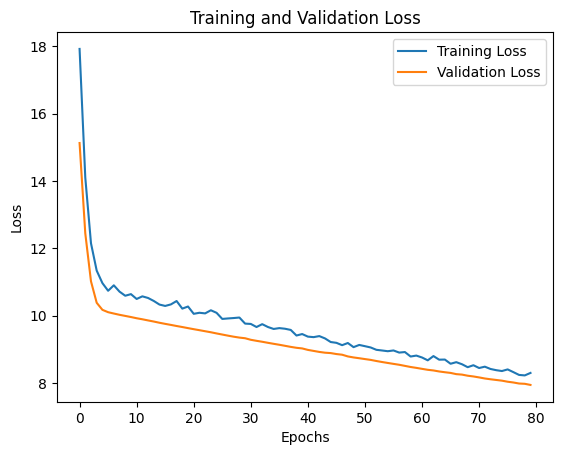

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 768)            │              0 │ text_input[0][0],      │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │        393,728 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ func_rating_input         │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │            128 │ func_rating_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 320)            │              0 │ dropout_1[0][0],       │
│                           │                        │                │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1)              │            321 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,576,517 (6.01 MB)

 Trainable params: 525,505 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,051,012 (4.01 MB)

# Testing our model

In [ ]:
test_texts = [ "How to improve focus and concentration?",
    "What are the side effects of lack of sleep?",
    "Best techniques to manage stress effectively?",
    "How does regular exercise impact mental health?",
    "What are the benefits of meditation and mindfulness?"]
X_text_test, X_mask_test = encode_text(pd.Series(test_texts), tokenizer, max_length=128)
X_func_test = np.array([5,4,3,4,2]).reshape(-1, 1)

predictions = model.predict([X_text_test, X_mask_test, X_func_test])

for i, text in enumerate(test_texts):
    print(f"Prompt: {text}")
    print(f"Predicted Score: {predictions[i][0]:.2f}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Prompt: How to improve focus and concentration?
Predicted Score: 3.69
--------------------------------------------------
Prompt: What are the side effects of lack of sleep?
Predicted Score: 3.25
--------------------------------------------------
Prompt: Best techniques to manage stress effectively?
Predicted Score: 3.17
--------------------------------------------------
Prompt: How does regular exercise impact mental health?
Predicted Score: 3.39
--------------------------------------------------
Prompt: What are the benefits of meditation and mindfulness?
Predicted Score: 3.11
--------------------------------------------------


## Create Repo on HF

In [ ]:
! pip install --upgrade huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.0/468.0 kB 27.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.28.1
    Uninstalling huggingface-hub-0.28.1:
      Successfully uninstalled huggingface-hub-0.28.1


In [ ]:
import os
from huggingface_hub import HfApi, login

os.environ["HUGGINGFACE_TOKEN"] = "Use your hugging face API key here"  # Replace with your token

hf_username = "Your username here"# Set your hf username here
repo_name = "my-tensorflow-model"# keep your personalized name for the model
repo_id = f"{hf_username}/{repo_name}"

token = os.environ.get("HUGGINGFACE_TOKEN")

login(token=token)

api = HfApi()

api.create_repo(repo_id=repo_id, exist_ok=True)

print(f"Repository created: https://huggingface.co/{repo_id}")

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Repository created: https://huggingface.co/Aditya-1911/my-tensorflow-model


## Push Artifacts on HF

In [ ]:
import pickle
import os
from huggingface_hub import HfApi
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

# Define save directory
model_dir = "./saved_model"
os.makedirs(model_dir, exist_ok=True)

# Save the model
model_path = os.path.join(model_dir, "model.keras")
model.save(model_path)

# Save the tokenizer as a pickle file
tokenizer_path = os.path.join(model_dir, "tokenizer.pkl")
with open(tokenizer_path, "wb") as f:
    pickle.dump(tokenizer, f)

# Upload model and tokenizer to Hugging Face
repo_id = f"Your_user_name/{repo_name}"  # Change as needed- Add your username
api = HfApi()

api.upload_file(path_or_fileobj=model_path, path_in_repo="model.keras", repo_id=repo_id)
api.upload_file(path_or_fileobj=tokenizer_path, path_in_repo="tokenizer.pkl", repo_id=repo_id)

print(f"Model and tokenizer successfully pushed to: https://huggingface.co/{repo_id}")

model.keras:   0%|          | 0.00/6.35M [00:00<?, ?B/s]

tokenizer.pkl:   0%|          | 0.00/630k [00:00<?, ?B/s]

Model and tokenizer successfully pushed to: https://huggingface.co/Aditya-1911/my-tensorflow-model


## Download Model Artifact from HF

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from huggingface_hub import hf_hub_download

# Ensure correct backend (optional)
#os.environ["KERAS_BACKEND"] = "jax"

# Define repo ID and model filename
repo_id = "Your_username/my-tensorflow-model"#-Add your username here
filename = "model.keras"

# Download the model
model_path = hf_hub_download(repo_id=repo_id, filename=filename)

# Define the registered function before loading
def bert_layer(inputs):
    return bert_model(inputs[0], attention_mask=inputs[1])[0][:, 0, :]

# Load the Keras model with custom objects
new_model = keras.models.load_model(model_path, custom_objects={"bert_layer": bert_layer})

print("Model loaded successfully!")


Model loaded successfully!


## Local Inference

In [ ]:
import pickle
from huggingface_hub import hf_hub_download
from tensorflow import keras
import numpy as np

# Download model
model_path = hf_hub_download(repo_id=repo_id, filename="model.keras")
new_model = keras.models.load_model(model_path)

# Download tokenizer
tokenizer_path = hf_hub_download(repo_id=repo_id, filename="tokenizer.pkl")

# Load the tokenizer
with open(tokenizer_path, "rb") as f:
    tokenizer = pickle.load(f)

print("Model and tokenizer loaded successfully!")

# Sample test data
test_texts = [
    "How to improve focus and concentration?",
    "What are the side effects of lack of sleep?",
    "Best techniques to manage stress effectively?",
    "How does regular exercise impact mental health?",
    "What are the benefits of meditation and mindfulness?",
    "Tips for maintaining a healthy work-life balance?",
    "How to boost productivity while working from home?",
    "What are the common causes of anxiety and how to cope?",
    "Does diet affect cognitive function and memory?",
    "How to build better habits for personal growth?",
    "What are the long-term effects of chronic stress?",
]

# Get max_length from model input shape
max_length = new_model.input_shape[0][1]

# Encode test text properly using BERT tokenizer
encoded_test = tokenizer(test_texts, padding='max_length', truncation=True, max_length=max_length, return_tensors="np")

X_text_test = np.array(encoded_test["input_ids"])
X_mask_test = np.array(encoded_test["attention_mask"])

# Dummy numeric input (func_rating)
X_func_test = np.array([5,4,3,4,2,1,3,4,2,2,3]).reshape(-1, 1)

# Make predictions
predictions = new_model.predict({"text_input": X_text_test, "attention_mask": X_mask_test, "func_rating_input": X_func_test})

# Display results
for i, text in enumerate(test_texts):
    print(f"Prompt: {text}")
    print(f"Predicted Rating: {predictions[i][0]:.2f}")
    print("-" * 50)


Model and tokenizer loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Prompt: How to improve focus and concentration?
Predicted Rating: 3.69
--------------------------------------------------
Prompt: What are the side effects of lack of sleep?
Predicted Rating: 3.25
--------------------------------------------------
Prompt: Best techniques to manage stress effectively?
Predicted Rating: 3.17
--------------------------------------------------
Prompt: How does regular exercise impact mental health?
Predicted Rating: 3.39
--------------------------------------------------
Prompt: What are the benefits of meditation and mindfulness?
Predicted Rating: 3.11
--------------------------------------------------
Prompt: Tips for maintaining a healthy work-life balance?
Predicted Rating: 2.55
--------------------------------------------------
Prompt: How to boost productivity while working from home?
Predicted Rating: 3.29
--------------------------------------------------
Prompt: What are 